In [30]:
import pandas as pd
import numpy as np

from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import pingouin as pg

from tqdm.auto import tqdm

In [8]:
df = pd.read_csv("C:/Users/Qwerty/ANALYSIS/my_hub/STATISTICS/data_folder/hw_bootstrap.csv", sep=";").drop(columns="Unnamed: 0")

In [9]:
df.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


# EDA

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   value              1000 non-null   object
 1   experimentVariant  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [13]:
df['value'] = df.value.str.replace(",", ".").astype(float)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [15]:
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [16]:
df.experimentVariant.unique()

array(['Control', 'Treatment'], dtype=object)

In [17]:
df.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [18]:
# Divide data into two grops

In [19]:
df_Control = df.query("experimentVariant == 'Control'")

In [20]:
df_Treatment = df.query("experimentVariant == 'Treatment'")

In [38]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # 1 sample data
    data_column_2, # 2 sample data
    boot_it = 1000, # Num of samples
    statistic = np.mean, # required statistics
    bootstrap_conf_level = 0.95 # significance
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # subsampling
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # return setting
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # using required statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    print('p_value_bootstrap: ', p_value)
        
    # visualization
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0, ymax=50, linestyle='--', color='b')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}


In [45]:
# Bootstrap with mean

  0%|          | 0/2000 [00:00<?, ?it/s]

p_value_bootstrap:  0.037964300960454014


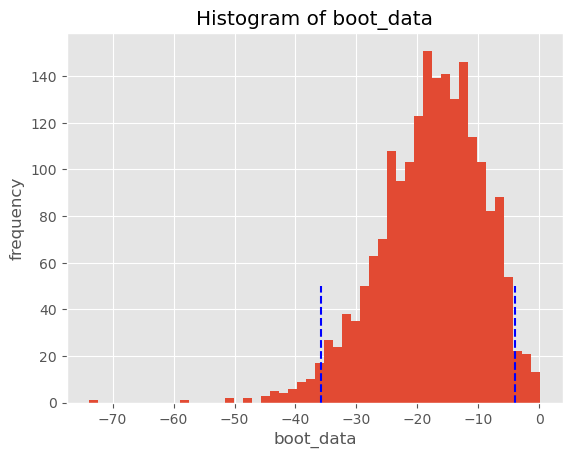

In [39]:
booted_data_mean = get_bootstrap(df_Control.value, df_Treatment.value, boot_it = 2000)

In [46]:
# Bootstrap with median

  0%|          | 0/2000 [00:00<?, ?it/s]

p_value_bootstrap:  0.881322731829721


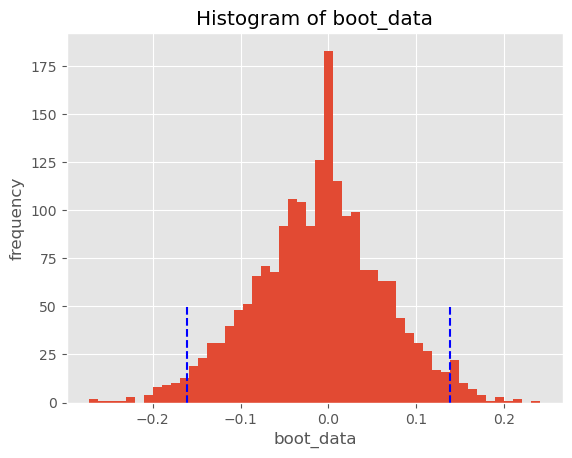

In [44]:
booted_data_median = get_bootstrap(df_Control.value, df_Treatment.value, boot_it = 2000, statistic = np.median)

In [47]:
# mann-whitney test
pg.mwu(df_Control.value, df_Treatment.value, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,124189.5,two-sided,0.859215,0.006484,0.496758


When utilizing bootstrap method on mean values, we observe noteworthy dissimilarities (bootstrap p-value: 0.04), which leads us to reject the null hypothesis. Nevertheless, while examining bootstrap data on median values (bootstrap p-value: 0.9) and applying the Mann-Whitney test (p-value: 0.86), the differences are no longer significant. This can be attributed to the existence of outliers in the analyzed data, which influences the mean values and thus the p-value obtained from bootstrapped mean data. As a result, we cannot support an alternative hypothesis.